## XGBoost Model - SageMaker

In this notebook, we build, train a [__XGBoost Classifier__](https://github.com/dmlc/xgboost) to predict the __Outcome Type__ field of our Austin Animal dataset.


1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Training and test datasets</a>
5. <a href="#5">Data processing with ColumnTransformer</a>
6. <a href="#6">Train a classifier using SageMaker</a>
7. <a href="#7">Deploy and test the classifier using SageMaker</a>

__Notes on [AWS SageMaker](https://docs.aws.amazon.com/sagemaker/index.html):__

* Fully managed machine learning service, to quickly and easily get you started on building and training machine learning models - we have seen that already! Integrated Jupyter notebook instances, with easy access to data sources for exploration and analysis, abstract away many of the messy infrastructural details needed for hands-on ML - you don't have to manage servers, install libraries/dependencies, etc.!


* Apart from building custom machine learning models in SageMaker notebooks, like we did so far, SageMaker also provides a few [built-in common machine learning algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) (check "SageMaker Examples" from your SageMaker instance top menu for a complete updated list) that are optimized to run efficiently against extremely large data in a distributed environment. The trained model can then be directly deployed into a production-ready hosted environment for easy access at inference. 

__Austin Animal Center Dataset__:

In this exercise, we are working with pet adoption data from __Austin Animal Center__. We have two datasets that cover intake and outcome of animals. Intake data is available from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and outcome is from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In order to work with a single table, we joined the intake and outcome tables using the "Animal ID" column and created a single __Austin_Animal_dataset.csv__ file. We also didn't consider animals with multiple entries to the facility to keep our dataset simple. If you want to see the original datasets and the merged data with multiple entries, they are available under `DATA/austin-animal` folder: Austin_Animal_Center_Intakes.csv, Austin_Animal_Center_Outcomes.csv and Austin_Animal_Center_Intakes_Outcomes.csv.

__Dataset schema:__ 
- __Pet ID__ - Unique ID of pet
- __Outcome Type__ - State of pet at the time of recording the outcome (0 = not placed, 1 = placed). This is the field to predict.
- __Sex upon Outcome__ - Sex of pet at outcome
- __Name__ - Name of pet 
- __Found Location__ - Found location of pet before entered the center
- __Intake Type__ - Circumstances bringing the pet to the center
- __Intake Condition__ - Health condition of pet when entered the center
- __Pet Type__ - Type of pet
- __Sex upon Intake__ - Sex of pet when entered the center
- __Breed__ - Breed of pet 
- __Color__ - Color of pet 
- __Age upon Intake Days__ - Age of pet when entered the center (days)
- __Age upon Outcome Days__ - Age of pet at outcome (days)


In [1]:
# # #Upgrade dependencies
# !pip install --upgrade pip
# !pip install --upgrade scikit-learn

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('../../DATA/austin-animal/Austin_Animal_dataset.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (95485, 13)


## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

We will look at number of rows, columns and some simple statistics of the dataset.

In [3]:
# Print the first five rows
# NaN means missing data
df.head()

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days
0,A794011,1.0,Neutered Male,Chunk,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby/White,730,730
1,A776359,1.0,Neutered Male,Gizmo,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,Chihuahua Shorthair Mix,White/Brown,365,365
2,A674754,0.0,Intact Male,NaN,12034 Research in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,Orange Tabby,6,6
3,A689724,1.0,Neutered Male,*Donatello,2300 Waterway Bnd in Austin (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black,60,60
4,A680969,1.0,Neutered Male,*Zeus,4701 Staggerbrush Rd in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,White/Orange Tabby,7,60


In [4]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95485 entries, 0 to 95484
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pet ID                 95485 non-null  object 
 1   Outcome Type           95485 non-null  float64
 2   Sex upon Outcome       95484 non-null  object 
 3   Name                   59138 non-null  object 
 4   Found Location         95485 non-null  object 
 5   Intake Type            95485 non-null  object 
 6   Intake Condition       95485 non-null  object 
 7   Pet Type               95485 non-null  object 
 8   Sex upon Intake        95484 non-null  object 
 9   Breed                  95485 non-null  object 
 10  Color                  95485 non-null  object 
 11  Age upon Intake Days   95485 non-null  int64  
 12  Age upon Outcome Days  95485 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 9.5+ MB


In [5]:
# This prints basic statistics for numerical columns
df.describe()

,Outcome Type,Age upon Intake Days,Age upon Outcome Days
count,95485.000000,95485.000000,95485.000000
mean,0.564005,703.436959,717.757313
std,0.495889,1052.252197,1055.023160
min,0.000000,0.000000,0.000000
25%,0.000000,30.000000,60.000000
50%,1.000000,365.000000,365.000000
75%,1.000000,730.000000,730.000000
max,1.000000,9125.000000,9125.000000


Let's separate model features and model target. 

In [6]:
print(df.columns)

Index(['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name', 'Found Location',
       'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake',
       'Breed', 'Color', 'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')


In [7]:
model_features = df.columns.drop('Outcome Type')
model_target = 'Outcome Type'

print('Model features: ', model_features)
print('Model target: ', model_target)

Model features:  Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color',
       'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')
Model target:  Outcome Type


We can explore the features set further, figuring out first what features are numerical or categorical. Beware that some integer-valued features could actually be categorical features, and some categorical features could be text features. 

In [8]:
import numpy as np
numerical_features_all = df[model_features].select_dtypes(include=np.number).columns
print('Numerical columns:',numerical_features_all)

print('\n')

categorical_features_all = df[model_features].select_dtypes(include='object').columns
print('Categorical columns:',categorical_features_all)


Numerical columns: Index(['Age upon Intake Days', 'Age upon Outcome Days'], dtype='object')


Categorical columns: Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color'],
      dtype='object')


#### Target distribution

Let's check our target distribution.

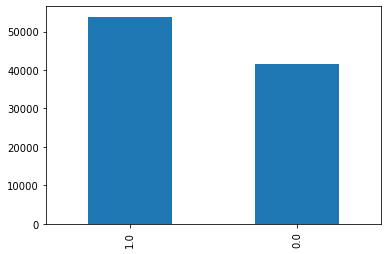

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

df[model_target].value_counts().plot.bar()
plt.show()

From the target plots we can identify whether or not we are dealing with imbalanced datasets - this means one result type is dominating the other one(s). 

Handling class imbalance is highly recommended, as the model performance can be greatly impacted. In particular the model may not work well for the infrequent classes, as there are not enough samples to learn patterns from, and so it would be hard for the classifier to identify and match those patterns. 

We might want to downsample the dominant class or upsample the rare the class, to help with learning its patterns. However, we should only fix the imbalance in training set, without changing the validation and test sets, as these should follow the original distribution. We will perform this task after train/test split. 


## 3. <a name="3">Select features to build the model</a>
(<a href="#0">Go to top</a>)

This time we build a model using all features. That is, we build a classifier including __numerical, categorical__ and __text__ features. 

In [10]:
# Grab model features/inputs and target/output

# can also grab less numerical features, as some numerical data might not be very useful
numerical_features = ['Age upon Intake Days', 'Age upon Outcome Days']

# dropping the IDs features, RescuerID and PetID here 
categorical_features = ['Sex upon Outcome', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake']

# from EDA, select the text features
text_features = ['Name', 'Found Location', 'Breed', 'Color']
    
model_features = numerical_features + categorical_features + text_features
model_target = 'Outcome Type'

#### Cleaning numerical features 

Age upon Intake Days


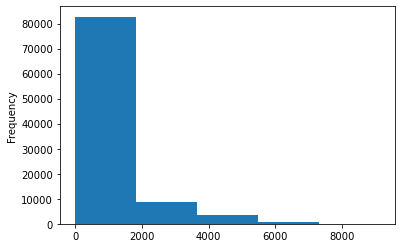

Age upon Outcome Days


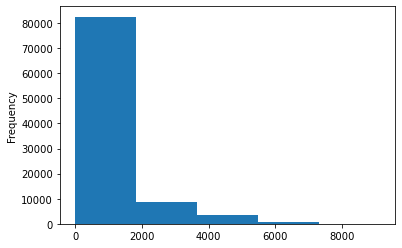

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

for c in numerical_features:
    print(c)
    df[c].plot.hist(bins=5)
    plt.show()

If for some histograms the values are heavily placed in the first bin, it is good to check for outliers, either checking the min-max values of those particular features and/or explore value ranges.

In [12]:
for c in numerical_features:
    print(c)
    print('min:', df[c].min(), 'max:', df[c].max())

Age upon Intake Days
min: 0 max: 9125
Age upon Outcome Days
min: 0 max: 9125


With __value_counts()__ function, we can increase the number of histogram bins to 10 for more bins for a more refined view of the numerical features.

In [13]:
for c in numerical_features: 
    print(c)
    print(df[c].value_counts(bins=10, sort=False))
    print('\n')

Age upon Intake Days
(-9.126, 912.5]     74835
(912.5, 1825.0]     10647
(1825.0, 2737.5]     3471
(2737.5, 3650.0]     3998
(3650.0, 4562.5]     1234
(4562.5, 5475.0]     1031
(5475.0, 6387.5]      183
(6387.5, 7300.0]       79
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Intake Days, dtype: int64


Age upon Outcome Days
(-9.126, 912.5]     74642
(912.5, 1825.0]     10699
(1825.0, 2737.5]     3465
(2737.5, 3650.0]     4080
(3650.0, 4562.5]     1263
(4562.5, 5475.0]     1061
(5475.0, 6387.5]      187
(6387.5, 7300.0]       81
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Outcome Days, dtype: int64




If any outliers are identified as very likely wrong values, dropping them could improve the numerical values histograms, and later overall model performance. While a good rule of thumb is that anything not in the range of `(Q1 - 1.5 IQR) and (Q3 + 1.5 IQR)` is an outlier, other rules for removing 'outliers' should be considered as well. 

Let's check missing values for these numerical features.

In [14]:
print(df[numerical_features].isna().sum())

Age upon Intake Days     0
Age upon Outcome Days    0
dtype: int64


If any missing values, as a quick fix, we can apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in both the train and test sets. So, you'll need to split your dataset first. Same goes for any other transformations we would like to apply to these numerical features, such as scaling. 


#### Cleaning categorical features 

Let's also examine the categorical features.

In [15]:
for c in categorical_features:
    print(c)
    print(df[c].unique())
    print('\n')

Sex upon Outcome
['Neutered Male' 'Intact Male' 'Intact Female' 'Unknown' 'Spayed Female'
 nan]


Intake Type
['Owner Surrender' 'Stray' 'Wildlife' 'Public Assist' 'Euthanasia Request'
 'Abandoned']


Intake Condition
['Normal' 'Nursing' 'Sick' 'Injured' 'Aged' 'Feral' 'Pregnant' 'Other'
 'Behavior' 'Medical']


Pet Type
['Cat' 'Dog' 'Other' 'Bird' 'Livestock']


Sex upon Intake
['Neutered Male' 'Intact Male' 'Intact Female' 'Unknown' 'Spayed Female'
 nan]




__Note on boolean type features__: Some categories might be of boolean type, like __False__ and __True__. The booleans will raise errors when trying to encode the categoricals with sklearn encoders, none of which accept boolean types. If using pandas get_dummies to one-hot encode the categoricals, there's no need to convert the booleans. However, get_dummies is trickier to use with sklearn's Pipeline and GridSearch. 

One way to deal with the booleans is to convert them to strings, by using a mask and a map changing only the booleans. Another way to handle the booleans is to convert them to strings by changing the type of all categoricals to 'str'. This will also affect the nans, basically performing imputation of the nans with a 'nans' placeholder value! 

Applying the type conversion to both categoricals and text features, takes care of the nans in the text fields as well. In case other imputations are planned for the categoricals and/or test fields, notice that the masking shown above leaves the nans unchanged.

In [16]:
df[categorical_features + text_features] = df[categorical_features + text_features].astype('str')

Let's have a check on missing values for the categorical features (and text features here).

In [17]:
print(df[categorical_features + text_features].isna().sum())

Sex upon Outcome    0
Intake Type         0
Intake Condition    0
Pet Type            0
Sex upon Intake     0
Name                0
Found Location      0
Breed               0
Color               0
dtype: int64


Converting categoricals into useful numerical features will also have to wait until after the train/test split.

#### Cleaning text features 

Also a good idea to look at the text fields. Text cleaning can be performed here, before train/test split, with less code. 

In [18]:
for c in text_features:
    print(c)
    print(df[c].unique()[:10])
    print('\n')

Name
['Chunk' 'Gizmo' 'nan' '*Donatello' '*Zeus' 'Artemis' '*Birch' '*Liza'
 'Star' 'Millie']


Found Location
['Austin (TX)' '7201 Levander Loop in Austin (TX)'
 '12034 Research in Austin (TX)' '2300 Waterway Bnd in Austin (TX)'
 '4701 Staggerbrush Rd in Austin (TX)'
 '10015 Lake Creek Pkwy in Austin (TX)' '9200 N Plaza Dr in Austin (TX)'
 'Hill Croft Drive & Loyola Lane in Austin (TX)'
 '2607 Garrettson Drive in Austin (TX)'
 '8711 Johnny Morris in Austin (TX)']


Breed
['Domestic Shorthair Mix' 'Chihuahua Shorthair Mix' 'Domestic Shorthair'
 'Opossum' 'Yorkshire Terrier Mix'
 'Jack Russell Terrier/Chihuahua Shorthair' 'Great Pyrenees Mix' 'Bat Mix'
 'Australian Cattle Dog Mix' 'Labrador Retriever Mix']


Color
['Brown Tabby/White' 'White/Brown' 'Orange Tabby' 'Black'
 'White/Orange Tabby' 'Blue/White' 'Brown Tabby' 'Gray' 'Calico'
 'Brown/Black']




We re-use the helper functions from the 'Text processing' notebook above.

__Warning__: cleaning stage can take a few minutes, depending on how much text is there to process.

In [19]:
# Prepare cleaning functions
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

# Clean the text features
for c in text_features:
    print('Text cleaning: ', c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]

Text cleaning:  Name
Text cleaning:  Found Location
Text cleaning:  Breed
Text cleaning:  Color


The cleaned text features are ready to be vectorized after the train/test split.

__Note__: More exploratory data analysis might reveal other important hidden atributes and/or relationships of the model features considered. 

## 4. <a name="4">Training and test datasets</a>
(<a href="#0">Go to top</a>)

We split our dataset into training (90%) and test (10%) subsets using sklearn's [__train_test_split()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [20]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.1, shuffle=True, random_state=23)

#### Target balancing

In [21]:
print('Training set shape:', train_data.shape)

print('Class 0 samples in the training set:', sum(train_data[model_target] == 0))
print('Class 1 samples in the training set:', sum(train_data[model_target] == 1))

print('Class 0 samples in the test set:', sum(test_data[model_target] == 0))
print('Class 1 samples in the test set:', sum(test_data[model_target] == 1))

Training set shape: (85936, 13)
Class 0 samples in the training set: 37499
Class 1 samples in the training set: 48437
Class 0 samples in the test set: 4132
Class 1 samples in the test set: 5417


__Important note:__ We want to fix the imbalance only in training set. We shouldn't change the validation and test sets, as these should follow the original distribution.

In [22]:
from sklearn.utils import shuffle

class_0_no = train_data[train_data[model_target] == 0]
class_1_no = train_data[train_data[model_target] == 1]

upsampled_class_0_no = class_0_no.sample(n=len(class_1_no), replace=True, random_state=42)

train_data = pd.concat([class_1_no, upsampled_class_0_no])
train_data = shuffle(train_data)

In [23]:
print('Training set shape:', train_data.shape)

print('Class 1 samples in the training set:', sum(train_data[model_target] == 1))
print('Class 0 samples in the training set:', sum(train_data[model_target] == 0))

Training set shape: (96874, 13)
Class 1 samples in the training set: 48437
Class 0 samples in the training set: 48437


## 5. <a name="5">Data processing with ColumnTransformer</a>
(<a href="#0">Go to top</a>)

Let's build a more complex pipeline today. We first build separate pipelines to handle the numerical, categorical, and text features, and then combine them into a composite pipeline along with an estimator, a [XGBoost Classifier](https://github.com/dmlc/xgboost) here.

   * For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's SimpleImputer, followed by a MinMaxScaler (don't have to scale features when using tree-based algorithms, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
   
   
   * In the categoricals pipeline, the __categorical_processor__ below, we impute with a placeholder value (no effect here as we already encoded the 'nan's), and encode with sklearn's OneHotEncoder. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
  
   
   * And, finally, also with memory usage in mind, we build two more pipelines, one for each of our text features, trying different vocabulary sizes.
   
The selective preparations of the dataset features are then put together into a collective __ColumnTransformer__.

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) # Shown in case is needed, not a must with Trees
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=50))
                                ])

# Preprocess 2nd text feature (larger vocabulary)
text_precessor_1 = Pipeline([
    ('text_vect_1', CountVectorizer(binary=True, max_features=150))
                                ])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('categorical_pre', categorical_processor, categorical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
                                    ]) 


## 6. <a name="6">Train a classifier</a>
(<a href="#0">Go to top</a>)

We use Amazon SageMaker XGBoost algorithm to build our classifier. We explain the components common to all Amazon SageMaker's algorithms including uploading data to Amazon S3, training a model, and setting up an endpoint for online inference. 

### Set up the SageMaker environment

Let's start by importing libraries we need.

In [25]:
import boto3
from os import path
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

### Upload datasets to Amazon S3

Amazon SageMaker XGBoost can train on data in either a `CSV` or `recordIO-wrapped-protobuf` format. For this example, we stick with CSV.  

So, let's write the data to Amazon S3 in recordio-protobuf format. We first create an io buffer wrapping the data, next we upload it to Amazon S3. Notice that the choice of bucket and prefix should change for different users and different datasets.

Amazon SageMaker requires that a `CSV file does not have a header record and that the target variable is in the first column`.

In [26]:
import os
import boto3
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = 'XGBoost-demo'
key = 'sample-data'

In [27]:
# Get train data and split intro train and validatuin
X_train, X_val, y_train, y_val = train_test_split(
    train_data[model_features],
    train_data[model_target],
    test_size=0.15,
    shuffle=True,
    random_state=23,
)

# Get test data
X_test = test_data[model_features]
y_test = test_data[model_target]

# Learn the transformation from training set and apply to validation and test
X_train = data_preprocessor.fit_transform(X_train).toarray()
X_val = data_preprocessor.transform(X_val).toarray()
X_test = data_preprocessor.transform(X_test).toarray()

In [28]:
import os

print("train_features shape = ", X_train.shape)
print("train_labels shape = ", y_train.shape)

train_df = pd.DataFrame(
    np.concatenate((y_train.values.reshape(-1, 1), X_train), axis=1)
)
train_df.to_csv("/tmp/train.csv", header=False, index=False)

boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train", key)
).upload_file("/tmp/train.csv")
os.remove("/tmp/train.csv")

s3_train_data = "s3://{}/{}/train/{}".format(bucket, prefix, key)
s3_train_data

train_features shape =  (82342, 235)
train_labels shape =  (82342,)


's3://sagemaker-us-east-1-757420736997/XGBoost-demo/train/sample-data'

It is also possible to provide validation data. This way we can get an test of the performance of the model from the training logs. In order to use this capability let's upload the validation data to Amazon S3 as well.

In [29]:
import os

print("validation_features shape = ", X_val.shape)
print("validation_labels shape = ", y_val.shape)

val_df = pd.DataFrame(np.concatenate((y_val.values.reshape(-1, 1), X_val), axis=1))
val_df.to_csv("/tmp/validation.csv", header=False, index=False)

boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation", key)
).upload_file("/tmp/validation.csv")
os.remove("/tmp/validation.csv")

s3_validation_data = "s3://{}/{}/validation/{}".format(bucket, prefix, key)
s3_validation_data

validation_features shape =  (14532, 235)
validation_labels shape =  (14532,)


's3://sagemaker-us-east-1-757420736997/XGBoost-demo/validation/sample-data'

### Fitting the classifier

We use the built-in Sagemaker [XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) below. 

In Amazon SageMaker, model training is done via an object called an __estimator__. When setting up the estimator we specify the location (in Amazon S3) of the training data, the path (again in Amazon S3) to the output directory where the model will be serialized, generic hyper-parameters such as the machine type to use during the training process, and kNN-specific hyper-parameters. Once the estimator is initialized, we can call its __.fit()__ method in order to do the actual training.

* __Compute power:__ We will use `train_instance_count` and `train_instance_type` parameters. This example uses `ml.m4.xlarge` resource for training. The instance_type is the machine type that will host the model. We can change the instance type for our needs (for example GPUs for neural networks).
* __Model type:__ `objective` is set to __`binary:logistic`__, as we have a classification problem here.
* __Hyperparameters:__ We update some of the parameters __`max_depth`__, __`num_rounds`__ and __`subsample`__. The __`subsample`__ parameter determines what percentage of randomly sampled points from the data set should be used for building the individual trees. Using all the data points is tempting and definitely can't hurt the quality of the outputs but is often either infeasible or simply too costly. The __`num_round`__ parameter determines how many rounds to use for boosting.

In [30]:
# set an output path where the trained model will be saved
output_path = "s3://{}/{}/output".format(bucket, prefix)

# set required XGboost hyperparameters
hyperparams = {
    "max_depth": "5",
    "subsample": "0.7",
    "verbosity": "1",
    "objective": "binary:logistic",
    "num_round": "50",
}

region = boto3.Session().region_name

# Create a container with XGBoost
container = sagemaker.image_uris.retrieve("xgboost", region, "latest")

# Call the XGBoost estimator object
XGBoost_estimator = sagemaker.estimator.Estimator(
    container,
    get_execution_role(),
    hyperparameters=hyperparams,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    output_path=output_path,
    sagemaker_session=sagemaker.Session(),
)

In [31]:
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

Because we’re training with the CSV file format, we’ll create TrainingInputs that our training function can use as a pointer to the files in S3.

In [32]:
from sagemaker.inputs import TrainingInput

# define the types of files
c_type = "csv"

train_input = TrainingInput(s3_train_data, content_type=c_type)
validation_input = TrainingInput(s3_validation_data, content_type=c_type)

In [33]:
%%time
XGBoost_estimator.fit({'train': train_input, 'validation': validation_input})

2021-06-30 20:21:25 Starting - Starting the training job...
2021-06-30 20:21:27 Starting - Launching requested ML instancesProfilerReport-1625084484: InProgress
......
2021-06-30 20:22:52 Starting - Preparing the instances for training......
2021-06-30 20:23:52 Downloading - Downloading input data...
2021-06-30 20:24:24 Training - Training image download completed. Training in progress..Arguments: train
[2021-06-30:20:24:25:INFO] Running standalone xgboost training.
[2021-06-30:20:24:25:INFO] File size need to be processed in the node: 89.0mb. Available memory size in the node: 23457.37mb
[2021-06-30:20:24:25:INFO] Determined delimiter of CSV input is ','
[20:24:25] S3DistributionType set as FullyReplicated
[20:24:25] 82342x235 matrix with 19350370 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-06-30:20:24:25:INFO] Determined delimiter of CSV input is ','
[20:24:25] S3DistributionType set as FullyReplicated
[20:24:25] 14532x235 matrix with 3415

## 7. <a name="7">Deploy and test the classifier using SageMaker</a>
(<a href="#0">Go to top</a>)

Now we test the best model with the best parameters on "unseen" data (our test data).

Before that, let's first see how the model works on the training dataset.

In [34]:
sagemaker.analytics.TrainingJobAnalytics(XGBoost_estimator._current_job_name, 
                                         metric_names = ['train:error']
                                        ).dataframe() 

,timestamp,metric_name,value
0,0.0,train:error,0.154421


If happy with the performance, it is time to deploy the model to another instance of our choice. We set up what is called an __endpoint__. An endpoint is a web service that given a request containing an unlabeled data point, or mini-batch of data points, returns a prediction(s). This allow us to use this model in production environment. 

Deployed endpoints can be used with other AWS Services such as Lambda and API Gateway. A nice walkthrough is available here: https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/ if you are interested.

We use a `ml.t2.medium` instance here, but can also use other instance types such as:, `ml.c4.xlarge` etc. 

__Warning: This process takes about 10-11 minutes to complete.__


In [46]:
%%time
from sagemaker.serializers import CSVSerializer

compiled_model = XGBoost_estimator
compiled_model.name = "deployed-xgboost-model"
endpoint = "model-test-xgboost-%s"%str(bucket.split('-')[-1])

XGBoost_predictor = compiled_model.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=CSVSerializer(),
    endpoint_name=endpoint 
)  # endpoint_name needs to be unique! Use AWS account number as part of name 

-------------------------!CPU times: user 402 ms, sys: 17.9 ms, total: 420 ms
Wall time: 12min 33s


We can now make some predictions; let's test with 500 points:

In [47]:
y_pred = XGBoost_predictor.predict(X_test[:500,:])

In [48]:
# Convert predictions to array
predictions = np.fromstring(y_pred.decode("utf-8"), sep=",") 

In [49]:
import pandas as pd

# Confusion matrix
pd.crosstab(
    index=y_test[:500].values,
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,0.0,1.0
actual,,
0.0,167,45
1.0,18,270


__If you're ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.__

In [50]:
XGBoost_predictor.delete_endpoint()